# Anemonefish Acoustics - Binary Classification Model

This notebook aims to develop a machine learning model to classify anemonefish calls from background noise. We'll test different model architectures to find the optimal solution.

## 1. Setup and Data Loading

In [30]:
# Import necessary libraries
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
from tqdm.notebook import tqdm

# For deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Set the random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [31]:
# Add the parent directory to the path so we can import the custom modules
sys.path.append('..')

# Import the data processing module
from src.anemonefish_acoustics.data_processing.data_preprocessing import DatasetBuilder, AudioProcessor, AnemoneMetadataParser

### 1.1 Configure Paths

In [32]:
# Define paths to data directories
# Update these paths according to your project structure
PROCESSED_WAVS_DIR = '../data/augmented_wavs'
NOISE_DIR = '../data/noise'
NOISE_CHUNKED_DIR = '../data/noise_chunked'
CACHE_DIR = '../data/cache'

# Create directories if they don't exist
for directory in [PROCESSED_WAVS_DIR, NOISE_DIR, NOISE_CHUNKED_DIR, CACHE_DIR]:
    os.makedirs(directory, exist_ok=True)

### 1.2 Initialize the DatasetBuilder

In [33]:
# Initialize the DatasetBuilder
dataset_builder = DatasetBuilder(
    processed_wavs_dir=PROCESSED_WAVS_DIR,
    noise_dir=NOISE_DIR,
    noise_chunked_dir=NOISE_CHUNKED_DIR,
    cache_dir=CACHE_DIR
)

### 1.3 Chunk Noise Files

This step processes long noise files into smaller chunks of 1 second each (as defined by the CHUNK_DURATION constant in the data_preprocessing module).

In [34]:
# Check if we need to chunk noise files
noise_files = dataset_builder.list_noise_files(use_chunked=True)
if not noise_files:
    print("No chunked noise files found. Chunking noise files...")
    dataset_builder.chunk_noise_files()
    noise_files = dataset_builder.list_noise_files(use_chunked=True)
    print(f"Created {len(noise_files)} chunked noise files.")
else:
    print(f"Found {len(noise_files)} existing chunked noise files.")

No chunked noise files found. Chunking noise files...


Chunking noise files: 100%|██████████| 8/8 [00:01<00:00,  5.64it/s]

Created 627 chunked noise files.


### 1.4 Explore the Dataset

In [35]:
# List anemonefish files
anemonefish_files = dataset_builder.list_anemonefish_files()
print(f"Number of anemonefish call files: {len(anemonefish_files)}")
if anemonefish_files:
    print(f"Example file: {os.path.basename(anemonefish_files[0])}")

Number of anemonefish call files: 1189
Example file: submission-Lui-A-NR-R2-R1-Submission_B27_2023_20230320-030015-Lui-B27-A-NR-withlabels-aup_9413_11358_aug_1_time_stretch-pitch_shift-volume_perturbation-add_noise.wav


In [36]:
# Build metadata dataframe for anemonefish calls
metadata_df = dataset_builder.build_metadata_dataframe()
print(f"Metadata dataframe shape: {metadata_df.shape}")
metadata_df

Extracting metadata: 100%|██████████| 1189/1189 [00:00<00:00, 137645.32it/s]

Metadata dataframe shape: (1189, 15)


,original_filename,behavior_type,reef,time_of_day,breeding,rank,interaction_with,category,start_time_ms,end_time_ms,duration_ms,id,year,tapename,file_path
0,submission-Lui-A-NR-R2-R1-Submission_B27_2023_...,submission,Lui,A,NR,R2,R1,Submission,9413,11358,1945,B27,2023,20230320-030015-Lui-B27-A-NR-withlabels-aup,../data/augmented_wavs/submission-Lui-A-NR-R2-...
1,territorial-Lui-A-NR-R2-Cooperation_B27_2023_2...,territorial,Lui,A,NR,R2,None,Cooperation,30472,30804,332,B27,2023,20230320-030015-Lui-B27-A-NR-withlabels-aup,../data/augmented_wavs/territorial-Lui-A-NR-R2...
2,territorial-Lui-A-NR-R2-Cooperation_B27_2023_2...,territorial,Lui,A,NR,R2,None,Cooperation,30472,30804,332,B27,2023,20230320-030015-Lui-B27-A-NR-withlabels-aup,../data/augmented_wavs/territorial-Lui-A-NR-R2...
3,territorial-Lui-A-NR-R2-Cooperation_B27_2023_2...,territorial,Lui,A,NR,R2,None,Cooperation,30472,30804,332,B27,2023,20230320-030015-Lui-B27-A-NR-withlabels-aup,../data/augmented_wavs/territorial-Lui-A-NR-R2...
4,competition-Lui-A-NR-R2-Cooperation_B27_2023_2...,competition,Lui,A,NR,R2,None,Cooperation,35460,36822,1362,B27,2023,20230320-030015-Lui-B27-A-NR-withlabels-aup,../data/augmented_wavs/competition-Lui-A-NR-R2...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1184,competition-GG2-M-NR-R3-Cooperation_B64_2023_2...,competition,GG2,M,NR,R3,None,Cooperation,149014,149794,780,B64,2023,20230316-220150-GG2-B64-M-NB-withlabels,../data/augmented_wavs/competition-GG2-M-NR-R3...
1185,competition-GG2-M-NR-R3-Cooperation_B64_2023_2...,competition,GG2,M,NR,R3,None,Cooperation,499630,499898,268,B64,2023,20230316-220150-GG2-B64-M-NB-withlabels,../data/augmented_wavs/competition-GG2-M-NR-R3...
1186,competition-GG2-M-NR-R3-Cooperation_B64_2023_2...,competition,GG2,M,NR,R3,None,Cooperation,520734,520894,160,B64,2023,20230316-220150-GG2-B64-M-NB-withlabels,../data/augmented_wavs/competition-GG2-M-NR-R3...
1187,submission-HG-A-R-R4-R1-Submission_B58_2023_20...,submission,HG,A,R,R4,R1,Submission,441180,442203,1023,B58,2023,20230302-050001-HG-B58-A-R-withlabels,../data/augmented_wavs/submission-HG-A-R-R4-R1...


Behavior type distribution:
behavior_type
territorial    547
competition    256
social         160
defence        109
submission      86
parental        16
aggression      15
Name: count, dtype: int64


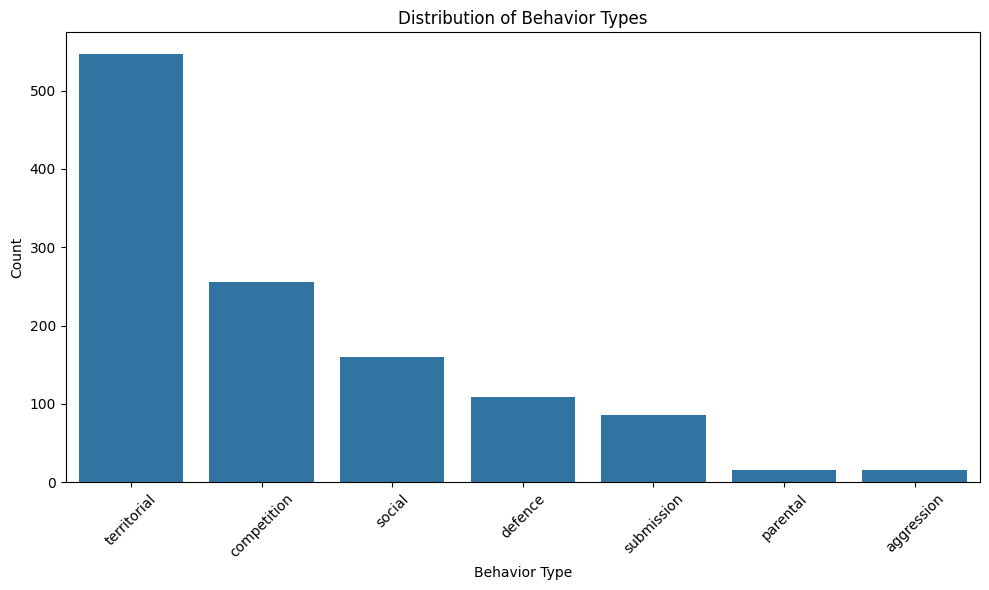

In [37]:
# Explore behavior types in the dataset
if 'behavior_type' in metadata_df.columns:
    behavior_counts = metadata_df['behavior_type'].value_counts()
    print("Behavior type distribution:")
    print(behavior_counts)
    
    # Plot behavior distribution
    plt.figure(figsize=(10, 6))
    sns.barplot(x=behavior_counts.index, y=behavior_counts.values)
    plt.title('Distribution of Behavior Types')
    plt.xlabel('Behavior Type')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

### 1.5 Visualize Audio Features

/Users/ferddei/anaconda3/envs/anemonefish_model/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=909
  warnings.warn(


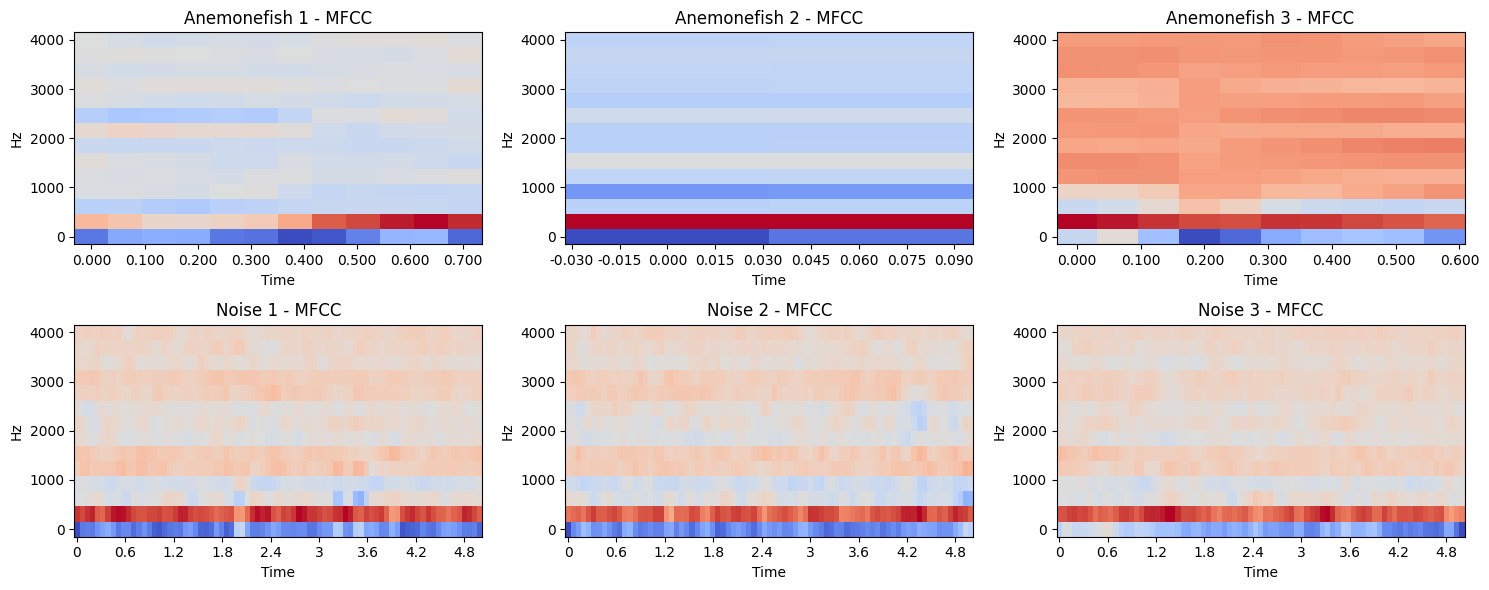

In [38]:
# Visualize MFCC features
dataset_builder.visualize_features(feature_type='mfcc', num_samples=3)

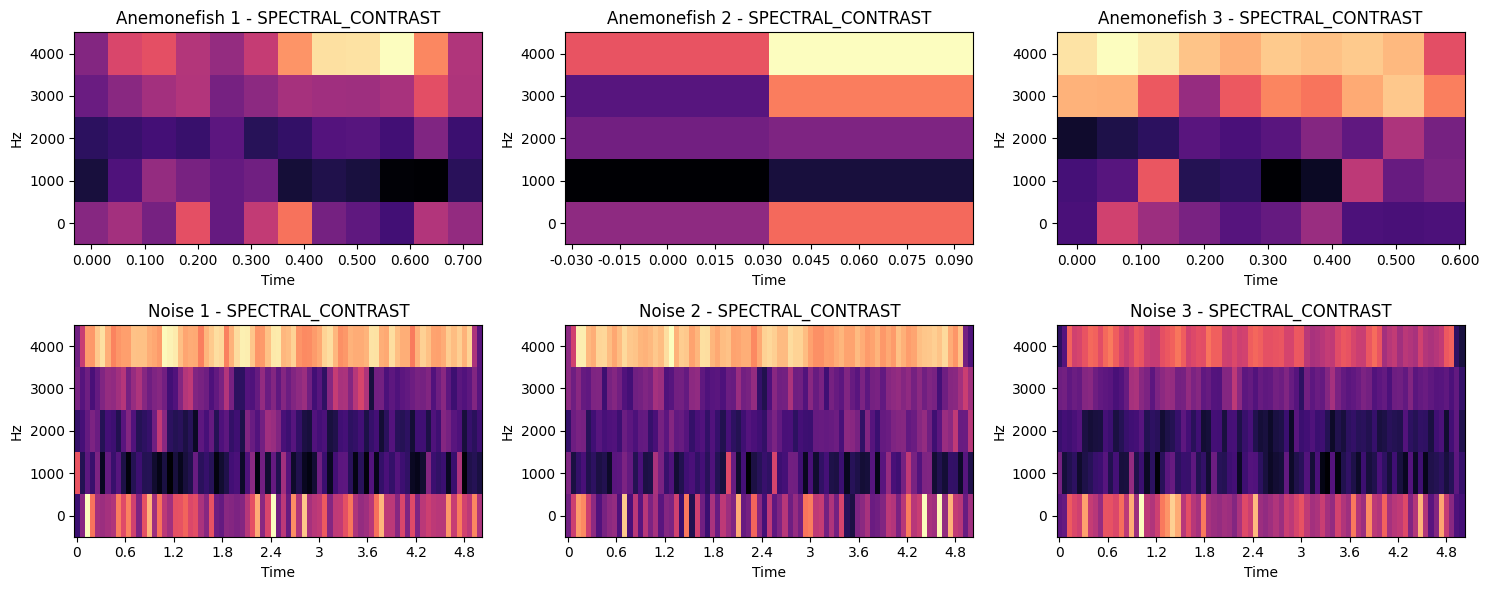

In [39]:
# Visualize spectral contrast features
dataset_builder.visualize_features(feature_type='spectral_contrast', num_samples=3)

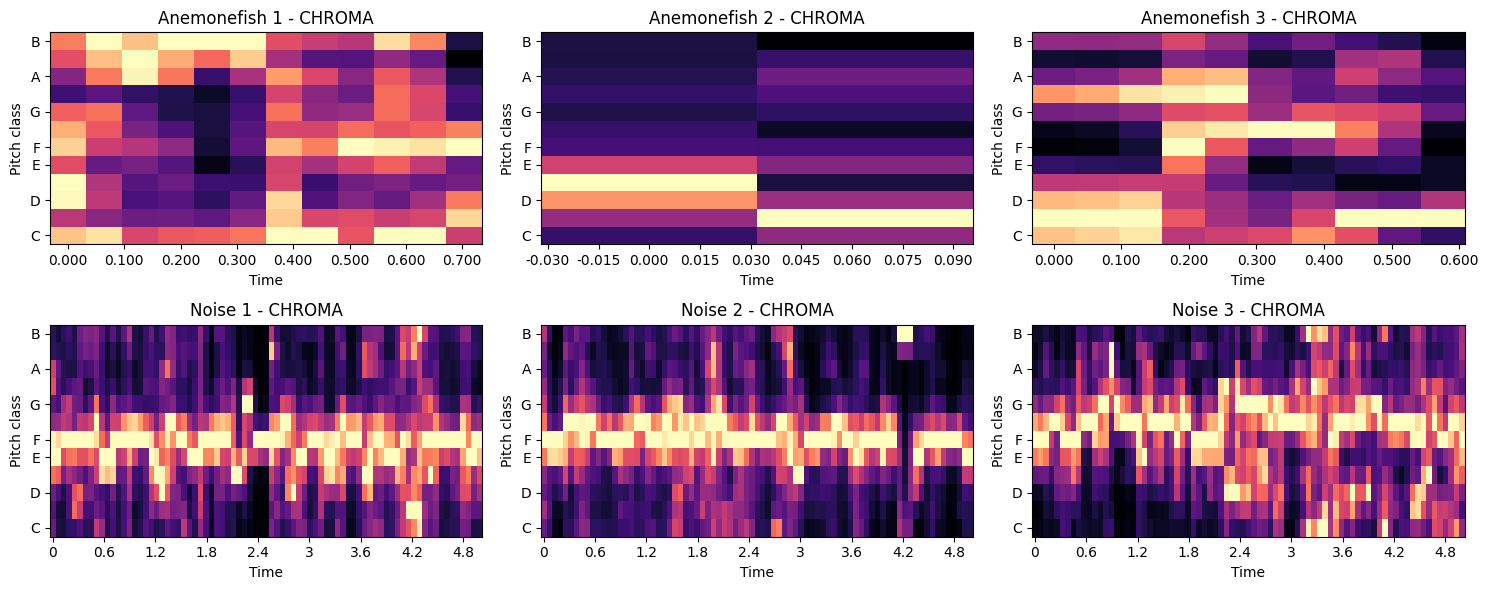

In [40]:
# Visualize chroma features
dataset_builder.visualize_features(feature_type='chroma', num_samples=3)

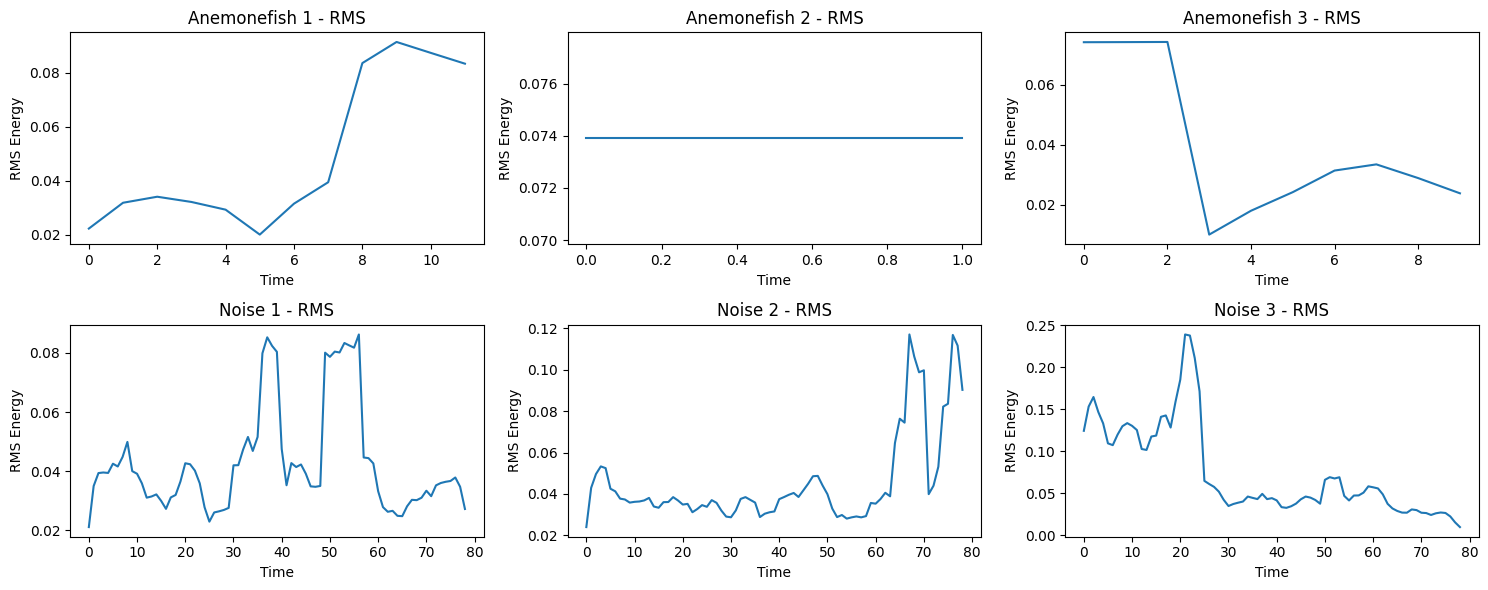

In [41]:
# Visualize RMS energy features
dataset_builder.visualize_features(feature_type='rms', num_samples=3)

### 1.6 Prepare the Dataset for Training

In [42]:
# Prepare the dataset (80% training, 20% testing)
X_train, X_test, y_train, y_test = dataset_builder.prepare_dataset_with_augmentation(test_size=0.2, random_state=42, use_augmentation=False, balance_ratio=3.0)

# Show the shapes of the features
print("Training set:")
for key, value in X_train.items():
    print(f"  {key}: {value.shape}")
print(f"  labels: {y_train.shape}")

print("\nTesting set:")
for key, value in X_test.items():
    print(f"  {key}: {value.shape}")
print(f"  labels: {y_test.shape}")

Using 1189 anemonefish files (including 0 augmented) and 627 noise files


Extracting features for anemonefish:   0%|          | 0/1189 [00:00<?, ?it/s]/Users/ferddei/anaconda3/envs/anemonefish_model/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1977
  warnings.warn(
/Users/ferddei/anaconda3/envs/anemonefish_model/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1521
  warnings.warn(
Extracting features for anemonefish:   2%|▏         | 19/1189 [00:00<00:06, 185.12it/s]/Users/ferddei/anaconda3/envs/anemonefish_model/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=707
  warnings.warn(
/Users/ferddei/anaconda3/envs/anemonefish_model/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=757
  warnings.warn(
Extracting features for anemonefish:   3%|▎         | 38/1189 [00:

Shape mismatch for mfcc: anemonefish (1189, 14, 43), noise (627, 14, 79)
Shape mismatch for spectral_contrast: anemonefish (1189, 5, 43), noise (627, 5, 79)
Shape mismatch for chroma: anemonefish (1189, 12, 43), noise (627, 12, 79)
Shape mismatch for rms: anemonefish (1189, 1, 43), noise (627, 1, 79)
Training set:
  mfcc: (1452, 14, 43)
  spectral_contrast: (1452, 5, 43)
  chroma: (1452, 12, 43)
  rms: (1452, 1, 43)
  labels: (1452,)

Testing set:
  mfcc: (364, 14, 43)
  spectral_contrast: (364, 5, 43)
  chroma: (364, 12, 43)
  rms: (364, 1, 43)
  labels: (364,)


### 1.7 Function to Prepare Data for Different Model Architectures

In [43]:
def prepare_data_for_model(X_train, X_test, y_train, y_test, feature_type='mfcc', model_type='cnn'):
    """
    Prepare data for different model architectures following standard conventions.
    
    Args:
        X_train: Dictionary of training features
        X_test: Dictionary of testing features
        y_train: Training labels
        y_test: Testing labels
        feature_type: Type of feature to use ('mfcc', 'spectral_contrast', 'chroma', 'rms', or 'combined')
        model_type: Type of model ('cnn', 'lstm', or 'mlp')
        
    Returns:
        Prepared data for the specified model type
    """
    # Get the appropriate features
    if feature_type == 'combined':
        # Handle combined features case
        feature_list_train = []
        feature_list_test = []
        
        for key in X_train.keys():
            # For all features, ensure they're in the format (samples, time_steps, features)
            # librosa originally gives (features, time_steps), so we need to transpose
            train_feature = X_train[key].transpose(0, 2, 1)  # Now (samples, time_steps, features)
            test_feature = X_test[key].transpose(0, 2, 1)
            
            feature_list_train.append(train_feature)
            feature_list_test.append(test_feature)
        
        # Concatenate along the feature dimension (axis=2)
        X_train_data = np.concatenate(feature_list_train, axis=2)
        X_test_data = np.concatenate(feature_list_test, axis=2)
    else:
        # Single feature type
        if feature_type not in X_train:
            raise ValueError(f"Feature type '{feature_type}' not found in the dataset")
        
        # Get the feature and transpose to (samples, time_steps, features)
        X_train_data = X_train[feature_type].transpose(0, 2, 1)
        X_test_data = X_test[feature_type].transpose(0, 2, 1)
    
    # Prepare data for different model types
    if model_type == 'cnn':
        # For CNN: (samples, time_steps, features, channels)
        X_train_data = X_train_data[..., np.newaxis]
        X_test_data = X_test_data[..., np.newaxis]
        
        print(f"CNN data shape - Training: {X_train_data.shape}, Testing: {X_test_data.shape}")
        # Should be something like (216, 43, 14, 1) for your data
    
    elif model_type == 'lstm':
        # For LSTM: (samples, time_steps, features)
        # Data is already in this format after transposing
        print(f"LSTM data shape - Training: {X_train_data.shape}, Testing: {X_test_data.shape}")
        # Should be something like (216, 43, 14) for your data
    
    elif model_type == 'mlp':
        # For MLP, flatten everything except batch dimension
        X_train_data = X_train_data.reshape(X_train_data.shape[0], -1)
        X_test_data = X_test_data.reshape(X_test_data.shape[0], -1)
        
        print(f"MLP data shape - Training: {X_train_data.shape}, Testing: {X_test_data.shape}")
        # Should be something like (216, 602) for your data (43*14)
    
    else:
        raise ValueError(f"Unknown model type: {model_type}")
    
    # Ensure labels are appropriate for binary classification
    # For binary classification in Keras, shape should be (samples,)
    if len(y_train.shape) > 1 and y_train.shape[1] == 1:
        y_train = y_train.ravel()
        y_test = y_test.ravel()
    
    return X_train_data, X_test_data, y_train, y_test

## 2. Model Development

In this section, we'll experiment with different model architectures for binary classification of anemonefish calls.

### 2.1 Example: Simple CNN Model

In [65]:
# Prepare data for CNN model using MFCC features
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = prepare_data_for_model(
    X_train, X_test, y_train, y_test, feature_type='spectral_contrast', model_type='cnn'
)

print(f"Training data shape: {X_train_cnn.shape}")
print(f"Testing data shape: {X_test_cnn.shape}")

CNN data shape - Training: (1452, 43, 5, 1), Testing: (364, 43, 5, 1)
Training data shape: (1452, 43, 5, 1)
Testing data shape: (364, 43, 5, 1)


In [71]:
# Define a simple CNN model
def create_simple_cnn(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',  # Use our custom loss
        metrics=['accuracy', 'precision', 'recall']
    )
    
    return model

In [72]:
# Create and train the model
cnn_model = create_simple_cnn(input_shape=X_train_cnn.shape[1:])
cnn_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 43, 5, 32)      │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 21, 2, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 21, 2, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 10, 1, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 640)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,993 (394.50 KB)

 Trainable params: 100,993 (394.50 KB)

 Non-trainable params: 0 (0.00 B)

In [73]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('models/best_cnn_model.keras', monitor='val_accuracy', save_best_only=True)

# Ensure the models directory exists
os.makedirs('models', exist_ok=True)

# Train the model
history = cnn_model.fit(
    X_train_cnn, y_train_cnn,
    validation_data=(X_test_cnn, y_test_cnn),
    epochs=50,
    batch_size=8,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9390 - loss: 0.2844 - precision: 0.9571 - recall: 0.9535 - val_accuracy: 0.9945 - val_loss: 0.0160 - val_precision: 1.0000 - val_recall: 0.9916
Epoch 2/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9850 - loss: 0.0741 - precision: 0.9869 - recall: 0.9910 - val_accuracy: 0.9973 - val_loss: 0.0040 - val_precision: 1.0000 - val_recall: 0.9958
Epoch 3/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9903 - loss: 0.0506 - precision: 0.9954 - recall: 0.9901 - val_accuracy: 1.0000 - val_loss: 1.3898e-04 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 4/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9919 - loss: 0.0277 - precision: 0.9964 - recall: 0.9916 - val_accuracy: 1.0000 - val_loss: 1.5493e-04 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 5/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9919 - loss: 0.0443 - precision: 0.9967 - recall: 0.9913 - val_accuracy: 1.0000 -

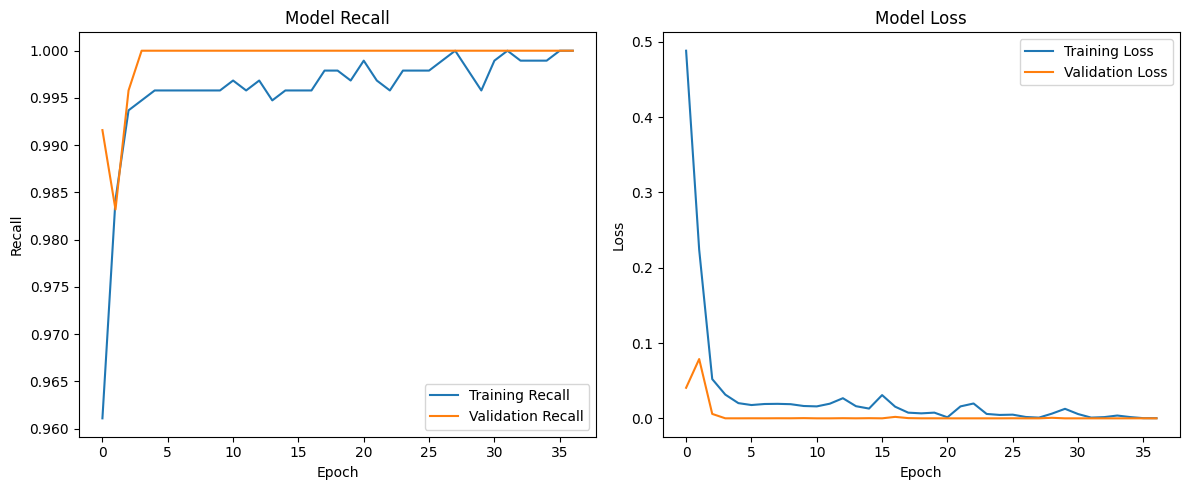

In [70]:
# Plot training history
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['recall'], label='Training Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.title('Model Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [64]:
# Evaluate the model on the test set
test_accuracy = cnn_model.evaluate(X_test_cnn, y_test_cnn)
print(f"Test accuracy: {test_accuracy}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.2277e-07 - precision: 1.0000 - recall: 1.0000
Test accuracy: [1.0512508197280113e-07, 1.0, 1.0, 1.0]


## 3. Next Steps

You can now experiment with different model architectures, feature types, and hyperparameters to improve the model's performance. Some ideas:

1. Try different feature combinations (MFCC, spectral contrast, chroma, RMS)
2. Experiment with different model architectures (CNN, LSTM, MLP, or hybrid models)
3. Apply data augmentation to increase the diversity of training samples
4. Try different hyperparameters (learning rate, batch size, number of layers, etc.)
5. Implement cross-validation to get more robust performance estimates
6. Add model explainability tools to understand what features are important for classification